In [1]:
#imports only
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, RandomizedSearchCV
from scipy import stats
import sklearn.preprocessing as skl_pre
import sklearn.linear_model as skl_lm
import sklearn.discriminant_analysis as skl_da
import sklearn.neighbors as skl_nb
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import sklearn.discriminant_analysis as skl_da


In [2]:
file_path = 'siren_data_train.csv'
data = pd.read_csv(file_path)

#Split the binary columns into zeroes and ones and use that going forwards
#data = pd.get_dummies(data, columns=["building","noise", "in_vehicle", "asleep","no_windows"])
data_copy = data.copy()

data.head()

,near_fid,near_x,near_y,near_angle,heard,building,xcoor,ycoor,noise,in_vehicle,asleep,no_windows,age
0,2712,1.998301e+06,9.011692e+06,-171.588672,1,0,1999193.0,9011824,0,0,0,0,59
1,2721,1.928907e+06,8.954624e+06,-51.208102,1,0,1928298.0,8955382,0,0,0,0,29
2,297,2.026384e+06,8.256164e+06,39.018754,1,0,2025706.0,8255615,0,0,0,0,32
3,739,1.743184e+06,8.052652e+06,15.046022,1,0,1742935.0,8052585,0,0,0,0,36
4,1852,1.350375e+06,7.909850e+06,144.603170,1,0,1350807.0,7909543,0,0,0,0,55


In [3]:
data.describe()

,near_fid,near_x,near_y,near_angle,heard,building,xcoor,ycoor,noise,in_vehicle,asleep,no_windows,age
count,5710.000000,5.710000e+03,5.710000e+03,5710.000000,5710.000000,5710.000000,5.710000e+03,5.710000e+03,5710.000000,5710.000000,5710.000000,5710.000000,5710.000000
mean,1888.705954,1.797385e+06,8.283496e+06,1.751993,0.760070,0.248687,1.796497e+06,8.283723e+06,0.190893,0.094046,0.006130,0.023643,50.635902
std,1320.046217,2.783430e+05,5.363099e+05,106.216736,0.427078,0.432290,2.789790e+05,5.369782e+05,0.393039,0.291918,0.078058,0.151947,18.630865
min,1.000000,1.244070e+06,7.430582e+06,-179.786267,0.000000,0.000000,1.244893e+06,7.432236e+06,0.000000,0.000000,0.000000,0.000000,18.000000
25%,538.000000,1.535191e+06,7.919606e+06,-90.278514,1.000000,0.000000,1.529848e+06,7.919276e+06,0.000000,0.000000,0.000000,0.000000,35.000000
50%,1901.000000,1.895376e+06,8.251327e+06,2.313685,1.000000,0.000000,1.891302e+06,8.251345e+06,0.000000,0.000000,0.000000,0.000000,50.000000
75%,2821.000000,2.003408e+06,8.368423e+06,95.330994,1.000000,0.000000,2.003743e+06,8.368852e+06,0.000000,0.000000,0.000000,0.000000,66.000000
max,4150.000000,2.686771e+06,1.040622e+07,179.992043,1.000000,1.000000,2.686256e+06,1.042743e+07,1.000000,1.000000,1.000000,1.000000,88.000000


# Create new features - distance, age group and distance group

### Create age group

#### Created new age buckets based on:
https://www.nidcd.nih.gov/health/statistics/hearing-loss-increases-with-age


![title](hearing_w_age.png)

In [4]:

#original bins
#age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
#age_labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']

# Create age groups column
#data['age_group'] = pd.cut(data['age'], bins=age_bins, labels=age_labels, right=False)

#new bins based on hearing with age
new_age_bins = [0, 40, 50, 60, 70, float('inf')]
new_age_labels = ['0-39', '40-49', '50-59', '60-69', '70+']

# Create age groups column with new bins
data['age_group1'] = pd.cut(data['age'], bins=new_age_bins, labels=new_age_labels, right=False)

#new age groups, only three buckets. Does it perform better to have fewer buckets?
#create new age_groups--------
#new bins based on hearing with age
new_age_bins = [0, 30, 60, float('inf')]
new_age_labels = ['Young', 'Middle-aged', 'Elderly']

# Create age groups column with new bins
data['age_group2'] = pd.cut(data['age'], bins=new_age_bins, labels=new_age_labels, right=False)






In [5]:
data

,near_fid,near_x,near_y,near_angle,heard,building,xcoor,ycoor,noise,in_vehicle,asleep,no_windows,age,age_group1,age_group2
0,2712,1.998301e+06,9.011692e+06,-171.588672,1,0,1999193.0,9011824,0,0,0,0,59,50-59,Middle-aged
1,2721,1.928907e+06,8.954624e+06,-51.208102,1,0,1928298.0,8955382,0,0,0,0,29,0-39,Young
2,297,2.026384e+06,8.256164e+06,39.018754,1,0,2025706.0,8255615,0,0,0,0,32,0-39,Middle-aged
3,739,1.743184e+06,8.052652e+06,15.046022,1,0,1742935.0,8052585,0,0,0,0,36,0-39,Middle-aged
4,1852,1.350375e+06,7.909850e+06,144.603170,1,0,1350807.0,7909543,0,0,0,0,55,50-59,Middle-aged
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5705,5,2.008871e+06,8.255775e+06,-176.234663,1,0,2009140.0,8255793,0,0,0,0,29,0-39,Young
5706,4069,1.981871e+06,8.270452e+06,45.691415,1,0,1981119.0,8269682,0,0,0,0,49,40-49,Middle-aged
5707,2170,1.463760e+06,8.074997e+06,-175.473118,1,0,1464308.0,8075040,0,0,0,0,62,60-69,Elderly
5708,1591,1.479843e+06,7.526377e+06,142.958054,1,0,1480125.0,7526164,0,0,0,0,37,0-39,Middle-aged


### Create distance

In [6]:
#add distance to horn
# Calculate Euclidean distance between person and nearest horn
data['dist'] = np.sqrt((data['xcoor'] - data['near_x'])**2 + (data['ycoor'] - data['near_y'])**2)


### Create distance group

In [7]:

# Add distance groups
# Create bins for distance ranging from 0 to 3000 with a step size of 100
step_size = 500
distance_bins = np.arange(0, 3100, step_size)

# Create labels for distance bins
distance_labels = [f'{i}-{i+step_size}' for i in range(0, 3000, step_size)]
# Append a bin edge for values greater than 3000
distance_bins = np.append(distance_bins, np.inf)
distance_labels.append('>3000')

# Assign each distance value to a corresponding bin
data['distance_groups'] = pd.cut(data['dist'], bins=distance_bins, labels=distance_labels, right=False)

In [8]:
## Create new combined features of noise and in_vehicle

In [9]:
# Create new combined features of noise and in_vehicle
# Assuming 'data' is your DataFrame containing the 'noise' and 'in_vehicle' features
data['noise_in_vehicle'] = ((data['noise'] == 1) & (data['in_vehicle'] == 1)).astype(int)
data['noise_not_in_vehicle'] = ((data['noise'] == 1) & (data['in_vehicle'] == 0)).astype(int)
data['not_noise_in_vehicle'] = ((data['noise'] == 0) & (data['in_vehicle'] == 1)).astype(int)
data['not_noise_not_in_vehicle'] = ((data['noise'] == 0) & (data['in_vehicle'] == 0)).astype(int)


### Check data

In [10]:
data.head()

,near_fid,near_x,near_y,near_angle,heard,building,xcoor,ycoor,noise,in_vehicle,...,no_windows,age,age_group1,age_group2,dist,distance_groups,noise_in_vehicle,noise_not_in_vehicle,not_noise_in_vehicle,not_noise_not_in_vehicle
0,2712,1.998301e+06,9.011692e+06,-171.588672,1,0,1999193.0,9011824,0,0,...,0,59,50-59,Middle-aged,901.283517,500-1000,0,0,0,1
1,2721,1.928907e+06,8.954624e+06,-51.208102,1,0,1928298.0,8955382,0,0,...,0,29,0-39,Young,972.006260,500-1000,0,0,0,1
2,297,2.026384e+06,8.256164e+06,39.018754,1,0,2025706.0,8255615,0,0,...,0,32,0-39,Middle-aged,872.340924,500-1000,0,0,0,1
3,739,1.743184e+06,8.052652e+06,15.046022,1,0,1742935.0,8052585,0,0,...,0,36,0-39,Middle-aged,257.804449,0-500,0,0,0,1
4,1852,1.350375e+06,7.909850e+06,144.603170,1,0,1350807.0,7909543,0,0,...,0,55,50-59,Middle-aged,529.686791,500-1000,0,0,0,1


# Generate dummies for newly created categorical data but keep original columns for the plots later

In [11]:
dummies = pd.get_dummies(data, columns=["age_group1", "age_group2", "distance_groups"])
keep_these_original_columns_for_plots = data[["distance_groups", "age_group1"]]
data = pd.concat([keep_these_original_columns_for_plots, dummies], axis=1)
data_copy = data.copy()


In [12]:
data.head()

,distance_groups,age_group1,near_fid,near_x,near_y,near_angle,heard,building,xcoor,ycoor,...,age_group2_Young,age_group2_Middle-aged,age_group2_Elderly,distance_groups_0-500,distance_groups_500-1000,distance_groups_1000-1500,distance_groups_1500-2000,distance_groups_2000-2500,distance_groups_2500-3000,distance_groups_>3000
0,500-1000,50-59,2712,1.998301e+06,9.011692e+06,-171.588672,1,0,1999193.0,9011824,...,0,1,0,0,1,0,0,0,0,0
1,500-1000,0-39,2721,1.928907e+06,8.954624e+06,-51.208102,1,0,1928298.0,8955382,...,1,0,0,0,1,0,0,0,0,0
2,500-1000,0-39,297,2.026384e+06,8.256164e+06,39.018754,1,0,2025706.0,8255615,...,0,1,0,0,1,0,0,0,0,0
3,0-500,0-39,739,1.743184e+06,8.052652e+06,15.046022,1,0,1742935.0,8052585,...,0,1,0,1,0,0,0,0,0,0
4,500-1000,50-59,1852,1.350375e+06,7.909850e+06,144.603170,1,0,1350807.0,7909543,...,0,1,0,0,1,0,0,0,0,0


# Generating samples

In [13]:
#random sampling
def split_train_test(data, test_ratio, random_state): 
    shuffled_indices = np.random.permutation(len(data)) if random_state is None else np.random.RandomState(random_state).permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

#stratified sampling, where we create a sample that takes the distribution of age into account
def stratified_sampling(data, test_ratio, important_data_column):
    split = StratifiedShuffleSplit(n_splits=1, test_size = test_ratio, random_state=42)
    for train_index, test_index in split.split(data, important_data_column):
        strat_train_set = data.loc[train_index]
        strat_test_set = data.loc[test_index]
    return strat_train_set, strat_test_set


#create samples
#train, test = stratified_sampling(data, 0.2, data["age"])
train, test = split_train_test(data, 0.2, random_state=42)

#print(len(test_set))
#print(len(train_set))

# Set X_train, X_test, y_train and y_test

In [14]:
#drop categorical values 
train = train.drop(columns=["distance_groups", "age_group1"], axis=1)
test = test.drop(columns=["distance_groups", "age_group1"], axis=1)

In [15]:
#right now we have all features, pls change

X_train = train.drop(columns=['heard'])
y_train = train['heard']

# Extract features and target for testing set
X_test = test.drop(columns=['heard'])
y_test = test['heard']


# (i) Does the distance to the nearest horn affect whether a person hears the siren or not?

In [16]:
data.columns

Index(['distance_groups', 'age_group1', 'near_fid', 'near_x', 'near_y',
       'near_angle', 'heard', 'building', 'xcoor', 'ycoor', 'noise',
       'in_vehicle', 'asleep', 'no_windows', 'age', 'dist', 'noise_in_vehicle',
       'noise_not_in_vehicle', 'not_noise_in_vehicle',
       'not_noise_not_in_vehicle', 'age_group1_0-39', 'age_group1_40-49',
       'age_group1_50-59', 'age_group1_60-69', 'age_group1_70+',
       'age_group2_Young', 'age_group2_Middle-aged', 'age_group2_Elderly',
       'distance_groups_0-500', 'distance_groups_500-1000',
       'distance_groups_1000-1500', 'distance_groups_1500-2000',
       'distance_groups_2000-2500', 'distance_groups_2500-3000',
       'distance_groups_>3000'],
      dtype='object')

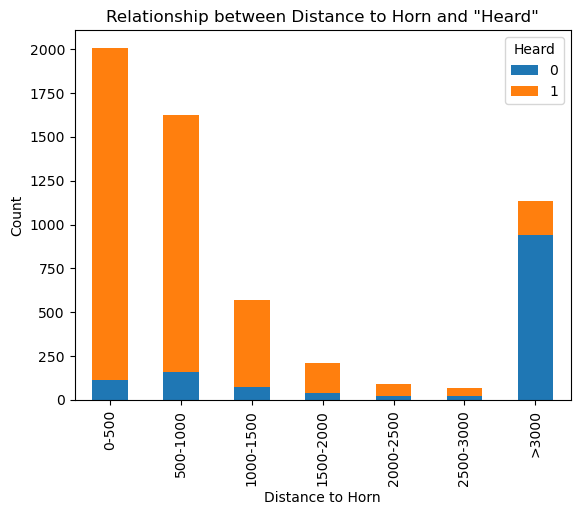

In [17]:
#Comparing distance and heard

#temp_data = data_copy

# Create stacked bar chart
pd.crosstab(data['distance_groups'], data['heard']).plot.bar(stacked=True)
plt.xlabel('Distance to Horn')
plt.ylabel('Count')
plt.title('Relationship between Distance to Horn and "Heard"')
plt.legend(title='Heard')
plt.show()

Text(0, 0.5, 'The procent hearing (%)')

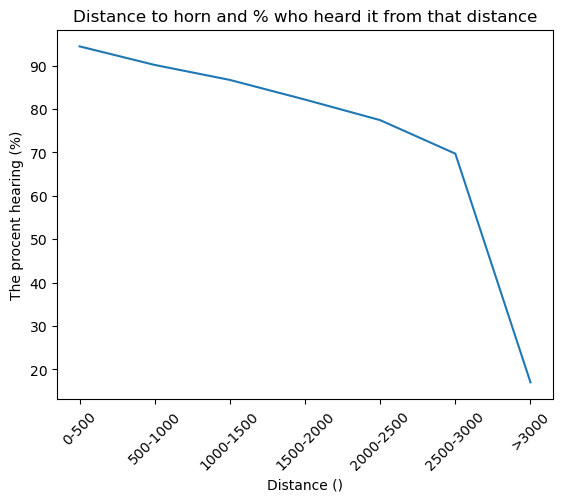

In [18]:
dist_num = data.pivot_table(index = ['distance_groups'], columns= 'heard', aggfunc='size')

dist_num[1] = dist_num[1].fillna(0)
dist_num[0] = dist_num[0].fillna(0)
dist_num_1 = np.array(dist_num[1])
dist_num_0 = np.array(dist_num[0])

dist_procent = (dist_num_1)/(dist_num_1+dist_num_0)*100

index_dist = np.array(dist_num.index)


plt.plot(index_dist, dist_procent)
plt.xlabel('Distance ()')
plt.title("Distance to horn and % who heard it from that distance")
plt.xticks(rotation=45)
plt.ylabel('The procent hearing (%)')

#### Is there a statistical difference between those that heard the signal and those that didn't given the distance?

In [19]:
from scipy import stats

# Split data into two groups based on 'heard' column
heard_group = data[data['heard'] == 1]['dist']
not_heard_group = data[data['heard'] == 0]['dist']


# Visualize distributions (optional)
# Example: sns.histplot(heard_group, label='Heard')
# Example: sns.histplot(not_heard_group, label='Not Heard')
# Add legend, labels, and titles as necessary

# Perform t-test
t_statistic, p_value = stats.ttest_ind(heard_group, not_heard_group)

# Interpret results
alpha = 0.05
if p_value < alpha:
    print("There is a statistically significant difference in the distributions.")
else:
    print("There is no statistically significant difference in the distributions.")


There is a statistically significant difference in the distributions.


# (ii) Are the people who hear the siren younger than the people who do not hear it?

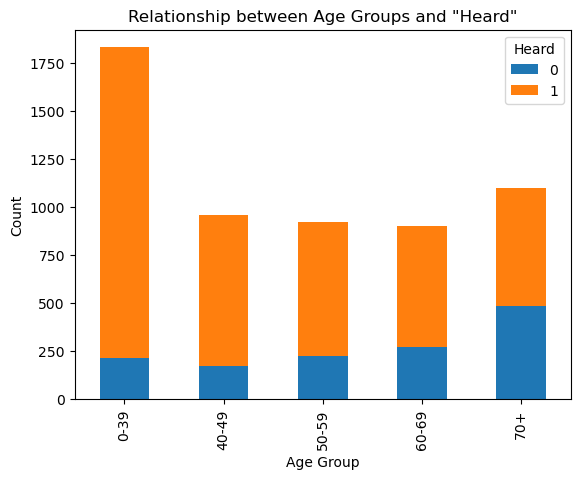

In [20]:

#Comparing age and heard

# Create stacked bar chart
pd.crosstab(data['age_group1'], data['heard']).plot.bar(stacked=True)
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Relationship between Age Groups and "Heard"')
plt.legend(title='Heard')
plt.show()

Text(0, 0.5, 'The procent hearing (%)')

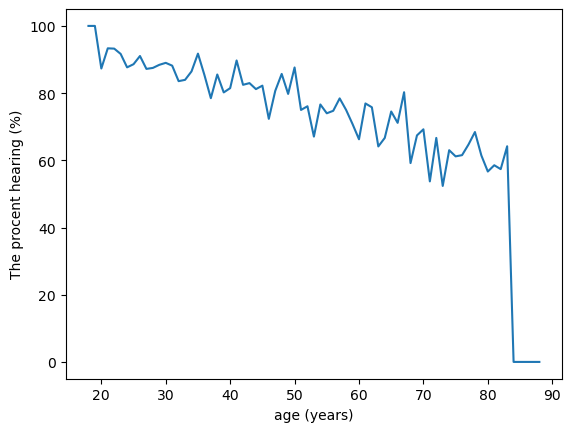

In [21]:
#The relationship between age and hearing
age_num = data_copy.pivot_table(index = ['age'], columns= 'heard', aggfunc='size')

age_num[1] = age_num[1].fillna(0)
age_num[0] = age_num[0].fillna(0)
age_num_1 = np.array(age_num[1])
age_num_0 = np.array(age_num[0])

age_procent = (age_num_1)/(age_num_1+age_num_0)*100 #procent som hör per åldersgrupp

index_age = np.array(age_num.index)

plt.plot(index_age, age_procent)
plt.xlabel('age (years)')
plt.ylabel('The procent hearing (%)')



# (iii) Does the direction towards the nearest horn affect whether a person hears the siren or not?

Text(0, 0.5, 'The procent hearing (%)')

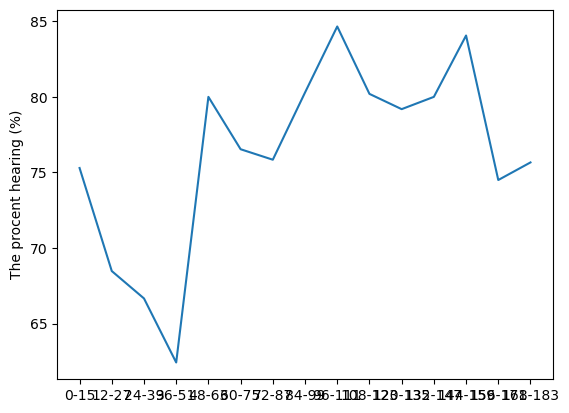

In [22]:
# Create bins for angle ranging from 0 to 2000 with a step size of 100
angle_bins = np.arange(0, 181, 12)

# Create labels for angle bins
angle_labels = [f'{i}-{i+15}' for i in range(0, 180, 12)]

# Assign each angle value to a corresponding bin
data['ange_span'] = pd.cut(data['near_angle'], bins=angle_bins, labels=angle_labels, right=False)

angle_num = data.pivot_table(index = ['ange_span'], columns= 'heard', aggfunc='size')

angle_num_1 = np.array(angle_num[1])
angle_num_0 = np.array(angle_num[0])

angle_procent = (angle_num_1 )/(angle_num_1 +angle_num_0)*100 #procent som hör

index_angle = np.array(angle_num.index)

plt.plot(index_angle, angle_procent)
plt.xlabel('')
plt.ylabel('The procent hearing (%)')


# Naive model to benchmark model performance to

In [ ]:
naive_predictions = np.ones_like(y_test)

print("Examples of predicted probabilities for the above classes: ")
with np.printoptions(suppress=True, precision=6):
    print(naive_predictions[0:5])

prediction_qda = np.empty(len(X_test), dtype=object)
prediction_qda = np.where(naive_predictions >= 0.5, 0, 1) #0 is not heard, 1 is heard
print("Five first predictions: ")
print(naive_predictions[0:5], "\n")


# Confusion matrix
print("Confusion matrix: \n")
print(pd.crosstab(naive_predictions, y_test), "\n")

#Accuracy
print(f"Accuracy: {np.mean(naive_predictions == y_test):.3f}")

# Random Forest

In [23]:
#Prepering the data for training and validation

data['dist'] = np.sqrt((data.near_x - data.xcoor)**2 + (data.near_y - data.ycoor)**2)

feat = ['near_fid', 'near_x', 'near_y', 'near_angle', 'xcoor', 'ycoor',
       'age', 'building_0', 'building_1', 'noise_0', 'noise_1', 'in_vehicle_0',
       'in_vehicle_1', 'asleep_0', 'asleep_1', 'no_windows_0', 'no_windows_1', 'dist']

x = data[feat] #inputs

y = data.heard # output

x = data[feat] #inputs

y = data['heard'] # output 
train_X, val_X, train_y, val_y = train_test_split(x,y, random_state=0, train_size=0.8)

KeyError: "['building_0', 'building_1', 'noise_0', 'noise_1', 'in_vehicle_0', 'in_vehicle_1', 'asleep_0', 'asleep_1', 'no_windows_0', 'no_windows_1'] not in index"

In [ ]:
model_tree = RandomForestClassifier()

par = {'n_estimators': stats.randint(50, 750), 'criterion':['gini', 'entropy'], 'max_depth': [4, 5, 6, 7, 8, 9], 'min_samples_split' : [1,2,3,4, 5, 6]}


RSC = RandomizedSearchCV(model_tree, param_distributions = par, n_iter = 10, cv=5, n_jobs = -1 )

RSC.fit(train_X, train_y)

model_tree = RSC.best_estimator_

model_tree.fit(train_X, train_y)

model_tree_prediction = model_tree.predict(val_X)

print(pd.crosstab(model_tree_prediction, val_y))
print(f"acc: {np.mean(model_tree_prediction == val_y)}")

In [ ]:
print(pd.crosstab(model_tree_prediction, val_y))
print(f"acc: {np.mean(model_tree_prediction == val_y)}")

# LDA and QDA

### LDA - best performing

In the other jupyterfile, I've explored which features increase accuracy. 
Some highlights is that "age" negatively affects accuracy when we have age groups
However "dist" positively affect accuracy when we have distance groups
Distance groups increase accuracy a little bit for some cases, that's why I'm keeping them
Features related to coordinates, suchb as xcoord, ycoord, near_x, near_y and near_angle do not affect accuracy, hence removal for simplicity
Multiple age groups (agegroup1) performs better than only have 3 age group buckets (agegroup2). 
Having both agegroup1 and agegroup2 togheter gives no effect


In [24]:
X_train.columns

Index(['near_fid', 'near_x', 'near_y', 'near_angle', 'building', 'xcoor',
       'ycoor', 'noise', 'in_vehicle', 'asleep', 'no_windows', 'age', 'dist',
       'noise_in_vehicle', 'noise_not_in_vehicle', 'not_noise_in_vehicle',
       'not_noise_not_in_vehicle', 'age_group1_0-39', 'age_group1_40-49',
       'age_group1_50-59', 'age_group1_60-69', 'age_group1_70+',
       'age_group2_Young', 'age_group2_Middle-aged', 'age_group2_Elderly',
       'distance_groups_0-500', 'distance_groups_500-1000',
       'distance_groups_1000-1500', 'distance_groups_1500-2000',
       'distance_groups_2000-2500', 'distance_groups_2500-3000',
       'distance_groups_>3000'],
      dtype='object')

In [31]:
# Set these:

#columns_to_remove = ['near_y', 'age', 'near_x', 'xcoor', 'ycoor', 'near_angle', 'noise', 'in_vehicle']
#columns_to_remove = ['age']
columns_to_remove = ['age_group2_Young','age_group2_Middle-aged', 'age_group2_Elderly','age']


#Let these be
current_X_train= X_train.copy().drop(columns=columns_to_remove, axis=1)
y_train = train['heard']
#print(current_X_train)

current_X_test = X_test.copy().drop(columns=columns_to_remove, axis=1)
y_test = test['heard']

#LDA

lda_model = skl_da.LinearDiscriminantAnalysis()
lda_model.fit(current_X_train, y_train)

#Predict

predict_prob_lda = lda_model.predict_proba(current_X_test)

print("The class order in the model: ")
print(lda_model.classes_)

print("Examples of predicted probabilities for the above classes: ")
with np.printoptions(suppress=True, precision=6):
    print(predict_prob_lda[0:5])

prediction_lda = np.empty(len(current_X_test), dtype=object)
prediction_lda = np.where(predict_prob_lda[:, 0] >= 0.5, 0, 1) #0 is not heard, 1 is heard
print("Five first predictions: ")
print(prediction_lda[0:5], "\n")


# Confusion matrix
print("Confusion matrix: \n")
print(pd.crosstab(prediction_lda, y_test), "\n")

#Accuracy
print(f"Accuracy: {np.mean(prediction_lda == y_test):.3f}")

The class order in the model: 
[0 1]
Examples of predicted probabilities for the above classes: 
[[0.999463 0.000537]
 [0.00034  0.99966 ]
 [0.049516 0.950484]
 [0.896767 0.103233]
 [0.012047 0.987953]]
Five first predictions: 
[0 1 1 0 1] 

Confusion matrix: 

heard    0    1
row_0          
0      234   29
1       56  823 

Accuracy: 0.926


### LDA Result

so best accuracy for LDA is 92.6%

### QDA

###  add this info to the report: https://stats.stackexchange.com/questions/29385/collinear-variables-in-multiclass-lda-training

In [ ]:
### As many values correlate together, one idea is to group them going forward. 
# Otherwise we likely get weird results below. But for now I will let it be, fix laterrr

In [36]:
#Likely the same values as in LDA is good for QDA

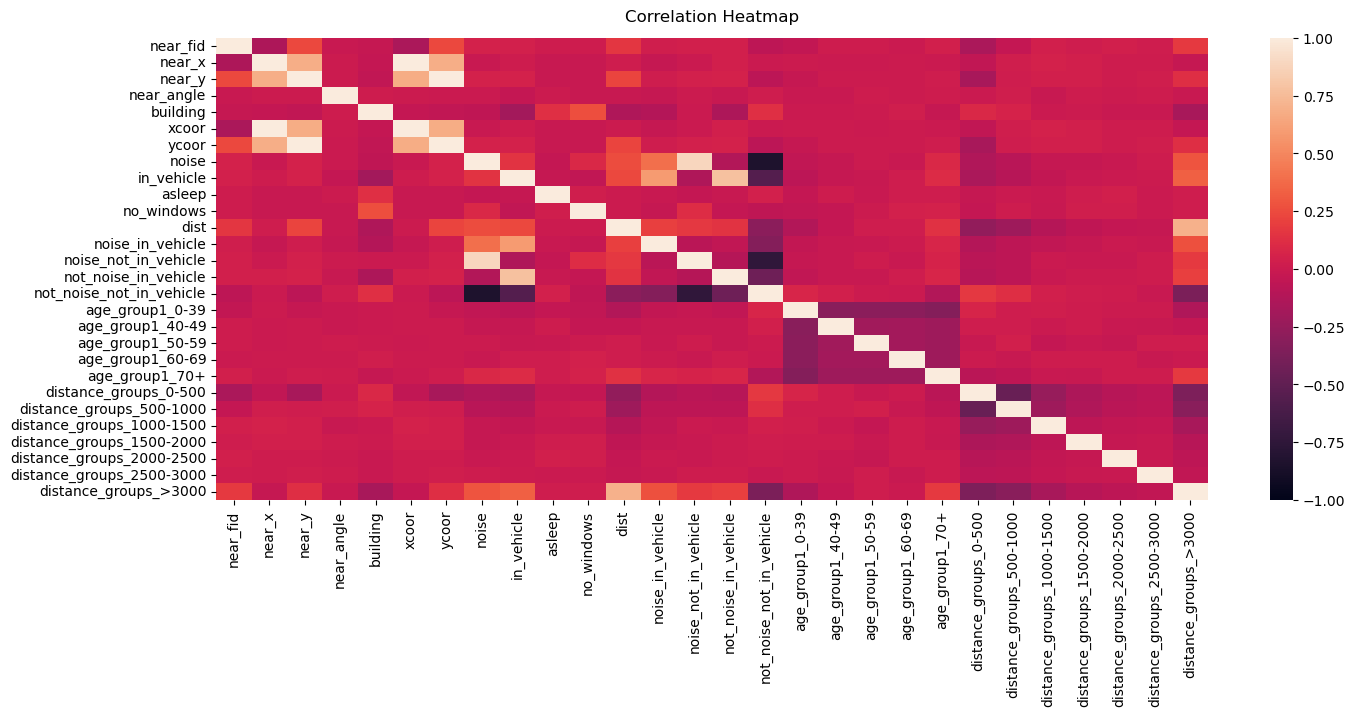

In [37]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(current_X_train.corr(), vmin=-1, vmax=1, annot=False)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [38]:
#However we see that some features, such as noise_in_vehicle etc correlate strongly to both noise and in_vehicle, better remove those newly created features



In [48]:
columns_to_remove = ['noise_in_vehicle', 'noise_not_in_vehicle', 'not_noise_in_vehicle',
       'not_noise_not_in_vehicle', 'near_x', 'near_y', 'near_angle', 'xcoor', 'ycoor', 'distance_groups_0-500', 'distance_groups_500-1000',
       'distance_groups_1000-1500', 'distance_groups_1500-2000',
       'distance_groups_2000-2500', 'distance_groups_2500-3000',
       'distance_groups_>3000', 'age_group1_0-39', 'age_group1_40-49', 'age_group1_50-59',
       'age_group1_60-69', 'age_group1_70+' , 'age_group2_Young', 'age_group2_Middle-aged',
       'age_group2_Elderly']
X_train_QDA = X_train.drop(columns=columns_to_remove , axis=1)
X_test_QDA = X_test.drop(columns=columns_to_remove , axis=1)

In [49]:
X_train_QDA.columns

Index(['near_fid', 'building', 'noise', 'in_vehicle', 'asleep', 'no_windows',
       'age', 'dist'],
      dtype='object')

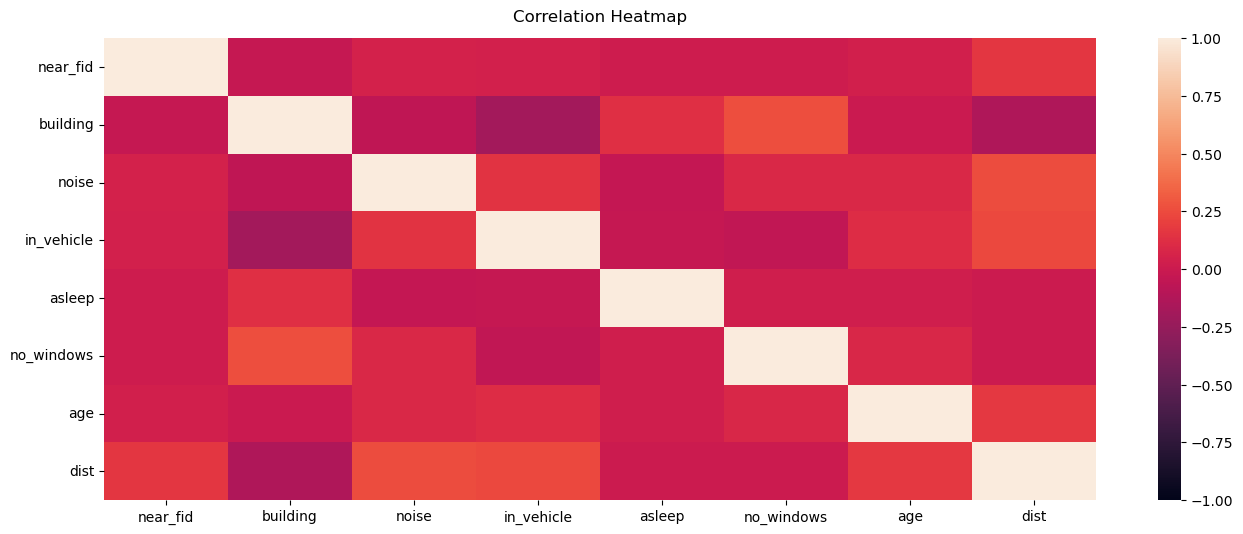

In [50]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(X_train_QDA.corr(), vmin=-1, vmax=1, annot=False)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [ ]:
#now we see no strong correlations in our matrix. However some are still purple

In [64]:
columns_to_remove = ['asleep', 'distance_groups_>3000', 'noise', 'age_group1_50-59', 'distance_groups_2500-3000']
#columns_to_remove = ['asleep', 'distance_groups_>3000', 'distance_groups_2500-3000']
X_train_QDA = X_train.drop(columns=columns_to_remove , axis=1)
X_test_QDA = X_test.drop(columns=columns_to_remove , axis=1)

In [65]:
qda_model = skl_da.QuadraticDiscriminantAnalysis()
qda_model.fit(X_train_QDA, y_train)

predict_prob_qda = qda_model.predict_proba(X_test_QDA)

print("The class order in the model: ")
print(qda_model.classes_)

print("Examples of predicted probabilities for the above classes: ")
with np.printoptions(suppress=True, precision=6):
    print(predict_prob_qda[0:5])

prediction_qda = np.empty(len(X_test_QDA), dtype=object)
prediction_qda = np.where(predict_prob_qda[:, 0] >= 0.5, 0, 1) #0 is not heard, 1 is heard
print("Five first predictions: ")
print(prediction_qda[0:5], "\n")


# Confusion matrix
print("Confusion matrix: \n")
print(pd.crosstab(prediction_qda, y_test), "\n")

#Accuracy
print(f"Accuracy: {np.mean(prediction_qda == y_test):.3f}")

The class order in the model: 
[0 1]
Examples of predicted probabilities for the above classes: 
[[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]
Five first predictions: 
[0 1 1 0 1] 

Confusion matrix: 

heard    0    1
row_0          
0      226   33
1       64  819 

Accuracy: 0.915


/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


### QDA result

So best accuracy I can perform for QDA is 91.5% accuracy. The values are still collinear, but if I remove them accuracy drops to roughly 24%



#### Assessment

In [72]:
def classification_report_interval(
    y_true,
    y_pred,
    labels=None,
    alpha = 0.01,
    union_bound_correction=True
):
    """Produces a classification report with precision, recall and accuracy
    It also uses Hoeffdings inequality to produce confidence intervals around
    each measurement. We can do this with or without multiple measurement
    correction (union bound correction).

    Example output is:
                labels           precision             recall

               0.0  0.88 : [0.50,1.00] 0.40 : [0.15,0.65]
               1.0  0.56 : [0.34,0.78] 0.93 : [0.65,1.00]

          accuracy                                        0.64 : [0.45,0.83]

    Parameters:
    y_true                          -- The true labels
    y_pred                          -- The predicted labels
    labels                          -- TODO
    alpha[0.01]                     -- The confidence level of the intervals
    union_bound_correction[True]    -- If we should compensate with the union bound because we
                                    have multiple intervals to compute in order to keep the level
                                    of confidence for all intervals jointly.

    Returns:
    a printable string.
    """
    import numpy as np

    def precision_recall(y_true,
        y_pred,
        labels=None,alpha=0.01, correction=1):
        p = []
        r = []
        f1 = []
        support = []
        for label in labels:
            y_true_pred_label = y_true[y_pred == label]
            precision = np.mean(y_true_pred_label == label)
            delta = (1/np.sqrt(len(y_true_pred_label)))*np.sqrt((1/2)*np.log(2*correction/alpha))
            p.append("%.2f : [%.2f,%.2f]" % (precision, np.maximum(precision-delta,0),np.minimum(precision+delta,1)))

            y_pred_true_label = y_pred[y_true == label]
            recall = np.mean(y_pred_true_label == label)
            delta = (1/np.sqrt(len(y_pred_true_label)))*np.sqrt((1/2)*np.log(2*correction/alpha))
            r.append("%.2f : [%.2f,%.2f]" % (recall, np.maximum(recall-delta,0),np.minimum(recall+delta,1)))

        return (p,r)

    def accuracy_interval(y_true,y_pred,alpha=0.01,correction=1):
        acc = np.mean(y_true == y_pred)
        delta = (1/np.sqrt(len(y_true)))*np.sqrt((1/2)*np.log(2*correction/alpha))
        return "%.2f : [%.2f,%.2f]" % (acc, np.maximum(acc-delta,0),np.minimum(acc+delta,1))

    digits = 18
    target_names = None
    if labels is None:
        labels = list(set(y_true).union(set(y_pred)))
        labels_given = False
    else:
        labels = np.asarray(labels)
        labels_given = True

    target_names = ["%s" % l for l in labels]

    headers = ["precision", "recall"]
    # compute per-class results without averaging
    # Simple correction using the union bound
    # We are computing 2 intervals for each label for precision and recall
    # In addition we are computing 2 intervals for accuracy
    # This is in total 2*n_labels+2
    if (union_bound_correction):
        correction = 2*len(labels)+2
    else:
        correction=1
    p, r = precision_recall(
        y_true,
        y_pred,
        labels=labels,
        alpha=alpha,
        correction=correction
    )

    rows = zip(target_names, p, r)

    name_width = max(len(cn) for cn in target_names)
    width = max(name_width, digits)
    head_fmt = "{:>{width}s} " + " {:>{digits}}" * len(headers)
    report = head_fmt.format("labels", *headers, width=width,digits=digits)
    report += "\n\n"
    row_fmt = "{:>{width}s} " + " {:>{digits}s}" * 2 + "\n"
    for row in rows:
        report += row_fmt.format(*row, width=width, digits=digits)
    row_fmt_acc = "{:>{width}s} " + " {:>{digits}s}" * 2 + " {:>{digits}s}""\n"
    report += "\n"
    accuracy = accuracy_interval(y_true,y_pred,alpha=alpha,correction=correction)
    report+=row_fmt_acc.format(*("accuracy","","",accuracy),width=width,digits=digits)

    return report

In [73]:
report_lda = classification_report_interval(
    y_test.values.reshape(-1),
    prediction_lda,
    alpha = 0.05,
)

print("Performance assessment LDA")
print("Confidence intervals are within brackets")
print(report_lda)

Performance assessment LDA
Confidence intervals are within brackets
            labels           precision             recall

                 0  0.89 : [0.79,0.99] 0.81 : [0.71,0.90]
                 1  0.94 : [0.88,0.99] 0.97 : [0.91,1.00]

          accuracy                                        0.93 : [0.88,0.97]



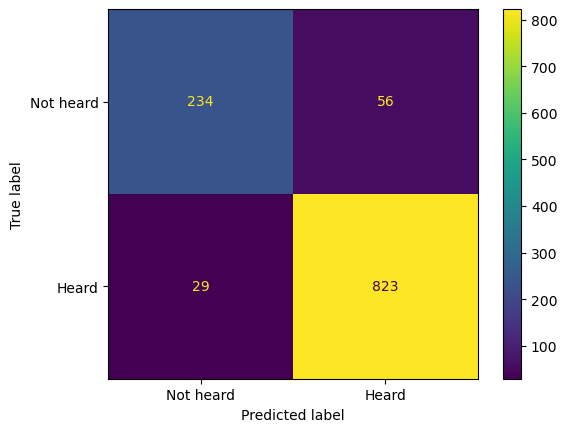

In [74]:
labels = ["Not heard", "Heard"]
cm = confusion_matrix(y_test, prediction_lda)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot();

In [75]:
report_qda = classification_report_interval(
    y_test.values.reshape(-1),
    prediction_qda,
    alpha = 0.05,
)

print("Performance assessment QDA")
print("Confidence intervals are within brackets")
print(report_qda)

Performance assessment QDA
Confidence intervals are within brackets
            labels           precision             recall

                 0  0.87 : [0.77,0.98] 0.78 : [0.68,0.88]
                 1  0.93 : [0.87,0.98] 0.96 : [0.90,1.00]

          accuracy                                        0.92 : [0.87,0.96]



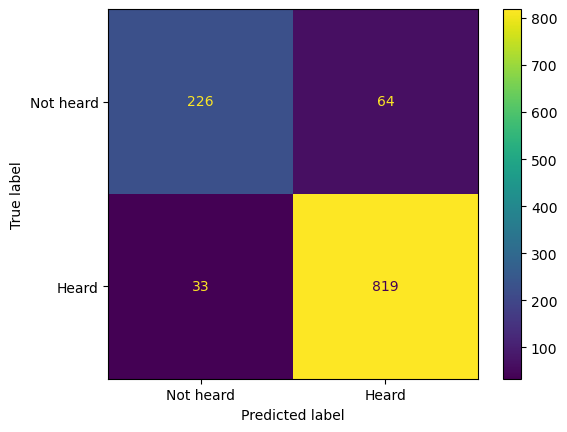

In [76]:
labels = ["Not heard", "Heard"]
cm = confusion_matrix(y_test, prediction_qda)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot();

# Extra, compare sampling methods

In [ ]:
#compare performances, stratified sampling is better for age group

import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

def split_comparison(data, target_column, test_size=0.2, random_state=None):
    # Original data overall performance
    overall_performance = data[target_column].value_counts(normalize=True)
    
    # Stratified Sampling
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    for train_index, test_index in split.split(data, data[target_column]):
        strat_train_set = data.loc[train_index]
        strat_test_set = data.loc[test_index]
    
    # Random Sampling
    rand_train_set, rand_test_set = train_test_split(data, test_size=test_size, random_state=random_state)
    
    # Calculate performance metrics for stratified sampling
    strat_train_performance = strat_train_set[target_column].value_counts(normalize=True)
    strat_test_performance = strat_test_set[target_column].value_counts(normalize=True)
    
    # Calculate performance metrics for random sampling
    rand_train_performance = rand_train_set[target_column].value_counts(normalize=True)
    rand_test_performance = rand_test_set[target_column].value_counts(normalize=True)
    
    # Calculate percentage error
    strat_train_error = ((strat_train_performance - overall_performance) / overall_performance) * 100
    strat_test_error = ((strat_test_performance - overall_performance) / overall_performance) * 100
    
    rand_train_error = ((rand_train_performance - overall_performance) / overall_performance) * 100
    rand_test_error = ((rand_test_performance - overall_performance) / overall_performance) * 100
    
    # Create comparison table
    comparison_df = pd.DataFrame({
        'Overall performance': overall_performance,
        'Stratified': strat_test_performance,
        'Random': rand_test_performance,
        'Strat. % error': strat_test_error,
        'Rand. % error': rand_test_error
    })
    
    return comparison_df

# Example usage:
comparison_table = split_comparison(data, target_column='age', test_size=0.2, random_state=42)
print(comparison_table)
